**import libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
import torch.nn.functional as F
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import scipy.io as sio
import sklearn.cluster
from sklearn.cluster import KMeans


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**custom cross entropy loss**

In [ ]:
K = 6

In [ ]:
class CrossEntropyLossFunction(Function):
    @staticmethod
    def forward(ctx, output, target):
        # output (64, 60)
        output = output - torch.max(output, dim=1, keepdim=True)[0].detach()
        output = F.softmax(output, dim=1)

        indices = ((target * K).view(-1, 1) + torch.arange(K)) % (K * 10)

        # tau (target)
        tau = torch.zeros_like(output)
        denum = torch.sum(torch.gather(output, 1, indices), dim=1) + 1e-12
        subclass_output = torch.gather(output, 1, indices)
        softmax_scores = subclass_output / denum[:, None]
        row_indices = torch.arange(indices.shape[0]).view(-1, 1)
        tau[row_indices, indices] = softmax_scores

        ctx.save_for_backward(output, tau)

        loss = torch.sum(-tau * output, dim=1).mean()

        return loss


    @staticmethod
    def backward(ctx, grad_output):
        # grad_output -> none, here we return dLoss/dy_hat
        output, tau = ctx.saved_tensors

        grad_input = (output - tau)/output.shape[0]  # grad_input -> dE_dwk

        return grad_input, None


In [ ]:
class CrossEntropyLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, outputs, targets):
        return CrossEntropyLossFunction.apply(outputs, targets)


**custom linear layer**

In [ ]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, input, W_pos, W_neg, beta, target):
        d_X_WPos = W_pos - input.unsqueeze(1)  # (64, 60, 784)
        d_X_WNeg = W_neg - input.unsqueeze(1)  # (64, 60, 784)

        ctx.save_for_backward(input, d_X_WPos, d_X_WNeg, beta, target)

        d_pos_2 = 0.5 * torch.sum(d_X_WPos ** 2, dim=-1)  # (64, 60)
        d_neg_2 = 0.5 * torch.sum(d_X_WNeg ** 2, dim=-1)  # (64, 60)

        d_neg_2_minus_d_pos_2 = d_neg_2 - d_pos_2  # (64, 60)

        out = beta * d_neg_2_minus_d_pos_2

        return out

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output: [batch_size, K*10], d(L)/d(out)
        input, d_X_WPos, d_X_WNeg, beta, target = ctx.saved_tensors
        grad_input = grad_W_pos = grad_W_neg = None

        # one hot labels
        indices = ((target * K).view(-1, 1) + torch.arange(K)) % (K * 10)
        split_grad_pos = torch.zeros_like(grad_output).scatter(1, indices, 1)
        split_grad_neg = torch.ones_like(grad_output) - split_grad_pos
        # gradient for beta
        d_pos_2 = 0.5 * torch.sum(d_X_WPos ** 2, dim=-1)
        d_neg_2 = 0.5 * torch.sum(d_X_WNeg ** 2, dim=-1)
        d_neg_2_minus_d_pos_2 = d_neg_2 - d_pos_2

        if ctx.needs_input_grad[0]:  # d(out)/d(X)
            grad_input = grad_output.unsqueeze(2) * (d_X_WPos - d_X_WNeg)
            grad_input = torch.mean(grad_input, dim=1)

        if ctx.needs_input_grad[1]: # d(out)/d(w_pos)
            grad_W_pos = - d_X_WPos * grad_output.unsqueeze(2) * split_grad_pos.unsqueeze(2)
            grad_W_pos = torch.mean(grad_W_pos, dim=0)

        if ctx.needs_input_grad[2]: # d(out)/d(w_neg)
            grad_W_neg = d_X_WNeg * grad_output.unsqueeze(2) * split_grad_neg.unsqueeze(2)
            grad_W_neg = torch.mean(grad_W_neg, dim=0)

        if ctx.needs_input_grad[3]: # d(out)/d(beta)
            grad_beta = grad_output * d_neg_2_minus_d_pos_2

        return grad_input, grad_W_pos, grad_W_neg, grad_beta, None

In [ ]:
class MyLinearLayer(nn.Module):
    def __init__(self, input_size, output_size, weight_init, subclassMeans, XTrain):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.W_pos = nn.Parameter(subclassMeans)

        if weight_init == 'mean':
            self.W_neg = nn.Parameter(torch.mean(XTrain, axis=0).repeat(K * 10, 1))

        elif weight_init == 'mean_samples_and_features':
            self.W_neg = nn.Parameter(subclassMeans + torch.mean(XTrain))

        elif weight_init == 'random':
            self.W_pos = nn.Parameter(0.01 * (2 * torch.rand(output_size * K, input_size) - 1))
            self.W_neg = nn.Parameter(0.01 * (2 * torch.rand(output_size * K, input_size) - 1))

        else:
            self.W_neg = nn.Parameter(subclassMeans * (1 - self.weight_init))

        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, target):
        return LinearFunction.apply(x, self.W_pos, self.W_neg, self.beta, target)


**Define Model**

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, input_size, output_size, weight_init, subclassMeans, XTrain):
        super().__init__()
        self.flatten = nn.Flatten()
        self.custom_layer = MyLinearLayer(input_size, output_size, weight_init, subclassMeans, XTrain)

    def forward(self, x, target):
        x = self.flatten(x)
        x = self.custom_layer(x, target)
        return x


**dataloader**

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [ ]:
import random

rand_seed = 5
def seed_worker(worker_id):
    # worker_seed = torch.initial_seed() % 2**32
    np.random.seed(rand_seed)
    random.seed(rand_seed)

g = torch.Generator()
g.manual_seed(rand_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(rand_seed)
np.random.seed(rand_seed)
random.seed(rand_seed)

In [ ]:
XTrain = sio.loadmat ('/content/drive/MyDrive/datasets/MNIST/MnistTrainX')['MnistTrainX']
yTrain = sio.loadmat ('/content/drive/MyDrive/datasets/MNIST/MnistTrainY')['MnistTrainY']

XTest = sio.loadmat ('/content/drive/MyDrive/datasets/MNIST/MnistTestX.mat')['MnistTestX']
yTest = sio.loadmat ('/content/drive/MyDrive/datasets/MNIST/MnistTestY')['MnistTestY']

Z = np.max(XTrain)
XTrain = XTrain / Z
XTest = XTest / Z

train_dataset = MNISTDataset(XTrain, yTrain)
test_dataset = MNISTDataset(XTest, yTest)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker, generator=g)

**find sublclass means**

In [ ]:
def findSubclasses(C, K, XTrain, yTrain, clusAlg):
    subclassMeans = torch.zeros([C * K, XTrain.shape[1]])

    for c in range(C):
        indices = torch.where(yTrain == c)[0]
        Xi = XTrain[indices]

        clusAlg.n_clusters = K
        clusAlg.fit(Xi)

        for k in range(K):
            cluster_samples = Xi[clusAlg.labels_ == k]
            subclass_mean = torch.mean(cluster_samples, dim=0)
            subclassMeans[c * K + k, :] = subclass_mean

    return subclassMeans

In [ ]:
clusAlg = sklearn.cluster.KMeans()
clusAlg.max_iter = 100
subclassMeans = findSubclasses(10, K, torch.tensor(XTrain), torch.tensor(yTrain), clusAlg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

**model and loss function**

In [ ]:
input_size = 784
output_size = 10
lr = 0.08
beta_lr = 0.001
weight_init = "random"

model = BasicModel(input_size, output_size, weight_init, subclassMeans, torch.tensor(XTrain))
optimizer = optim.SGD([
    {'params': model.custom_layer.W_pos, 'lr': lr},
    {'params': model.custom_layer.W_neg, 'lr': lr},
    {'params': model.custom_layer.beta, 'lr': beta_lr}
], lr=0.0)

criterion = CrossEntropyLoss()

In [ ]:
# based on K
C = 10
L = C * K
label_dict = np.zeros(L)
idx = 0
for c in range (C):
    for k in range (K):
        label_dict[idx] = c
        idx += 1
label_dict = torch.LongTensor(label_dict)
label_dict

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9])

In [ ]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=30):
    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        num_samples = len(dataloader.dataset)
        num_batches = len(dataloader)
        running_corrects = 0
        running_loss = 0.0
        for index, (inputs, labels) in enumerate(dataloader):
            outputs = model(inputs, labels)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            _, preds_subclass = torch.max(outputs, dim=1)
            preds = label_dict[preds_subclass]
            running_corrects += torch.sum(preds == labels.squeeze())
            running_loss += loss.item()

        epoch_acc = (running_corrects / num_samples) * 100
        epoch_loss = (running_loss / num_batches)
        print(f"epoch {epoch+1} -> Loss: {epoch_loss}, acc: {epoch_acc}")
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

epoch 1 -> Loss: -0.018711067398569224, acc: 52.119998931884766
epoch 2 -> Loss: -0.024557854662508344, acc: 70.83332824707031
epoch 3 -> Loss: -0.040660855372243725, acc: 70.65833282470703
epoch 4 -> Loss: -0.10336277409117105, acc: 70.39833068847656
epoch 5 -> Loss: -0.21468943821341752, acc: 75.49666595458984
epoch 6 -> Loss: -0.33301586772142444, acc: 81.0616683959961
epoch 7 -> Loss: -0.43733132034857897, acc: 84.0250015258789
epoch 8 -> Loss: -0.5159008604313519, acc: 85.38667297363281
epoch 9 -> Loss: -0.5698983508513681, acc: 86.20999908447266
epoch 10 -> Loss: -0.6062622229808937, acc: 86.82666778564453
epoch 11 -> Loss: -0.6311870848954614, acc: 87.25666046142578
epoch 12 -> Loss: -0.649172153045882, acc: 87.67333984375
epoch 13 -> Loss: -0.6620984381195832, acc: 88.0566635131836
epoch 14 -> Loss: -0.6720506569851182, acc: 88.39833068847656
epoch 15 -> Loss: -0.6795562311911634, acc: 88.72833251953125
epoch 16 -> Loss: -0.6854283667957859, acc: 88.99666595458984
epoch 17 -> L

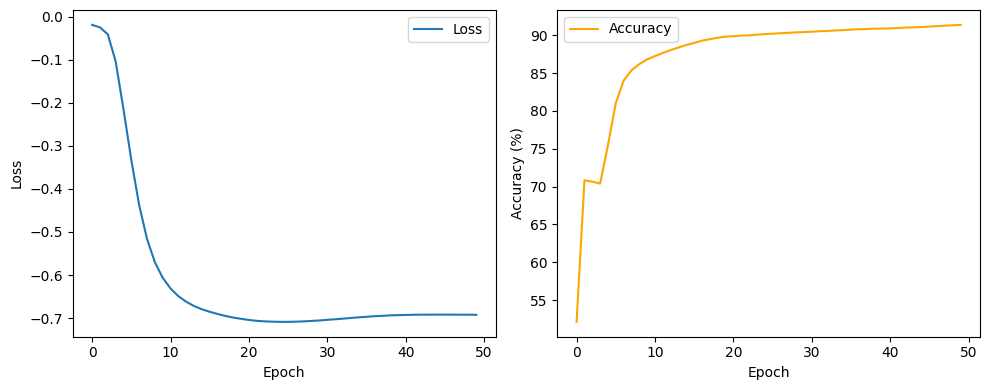

In [ ]:
train(model, train_loader, criterion, optimizer)

In [ ]:
def classifyByMaxClassifier(X_test):
    N, dim = X_test.shape
    W_pos = model.custom_layer.W_pos
    W_neg = model.custom_layer.W_neg

    W_pos_2 = torch.sum(W_pos**2, dim=1)
    W_neg_2 = torch.sum(W_neg**2, dim=1)

    beta = 1
    A = beta * (W_pos - W_neg)
    b = -0.5 * beta * (W_pos_2 - W_neg_2)

    out = torch.mm(X_test, A.t()) + b
    max_indices = torch.argmax(out, dim=1)

    y_pred = label_dict[max_indices]
    return y_pred

In [ ]:
import sklearn.cluster

yHat = classifyByMaxClassifier(torch.tensor(XTest).float())
yHat = np.array(yHat, dtype='int')
outVal = sklearn.metrics.accuracy_score(yTest, yHat)
print(f'test accuracy: {outVal}')

test accuracy: 0.917


In [ ]:
confusion = sklearn.metrics.confusion_matrix(yTest, yHat)
confusion

array([[ 963,    0,    0,    2,    0,    5,    7,    1,    2,    0],
       [   0, 1109,    2,    5,    0,    1,    4,    0,   14,    0],
       [  11,   11,  914,   16,    8,    4,   15,   19,   22,   12],
       [   5,    5,   21,  920,    0,   19,    3,   16,   11,   10],
       [   2,    5,    5,    0,  917,    2,   11,    1,    3,   36],
       [  13,    3,    4,   37,    5,  780,   15,    7,   16,   12],
       [  14,    4,    4,    1,    7,   12,  912,    2,    2,    0],
       [   5,   21,   21,    3,    7,    0,    0,  942,    2,   27],
       [   9,    7,   12,   38,   11,   24,   17,   16,  827,   13],
       [  12,    9,    5,   14,   46,    7,    1,   21,    8,  886]])

In [ ]:
W_pos = model.custom_layer.W_pos.detach().numpy()
W_neg = model.custom_layer.W_neg.detach().numpy()

def GenerateImagesOfWeights(width, height, color='color',
                    n_images=1, rows=None, cols=None, eps=0, weight='diff'):
    if weight == 'diff':
        A = W_pos - W_neg
    elif weight == 'pos':
        A = W_pos
    elif weight == 'neg':
        A = W_neg
    else:
        assert(0)

    n_features_per_image = rows * cols  # (A.shape[0] + 1) // n_images
    if rows == None or cols == None:
        cols = int(np.sqrt(A.shape[0] - 1)) + 1
        rows = (A.shape[0] + cols - 1) // cols
    images = []
    for picture in range(n_images):
        img = np.ones([rows * (height + 1), cols * (width + 1), 3])
        for nn in range(n_features_per_image):
            n = picture * n_features_per_image + nn
            if (n >= A.shape[0]):
                continue
            j = nn // cols
            i = nn % cols
            idx2 = i * (height + 1)
            idx1 = j * (width + 1)
            T = max(-np.min(A[n, :]), np.max(A[n, :])) + eps
            if color == 'color':
                arr_pos = np.maximum(A[n,:] / T, 0)
                arr_neg = np.maximum(-A[n,:] / T, 0)
                mcimg_pos = np.reshape(arr_pos, [height, width])
                mcimg_neg = np.reshape(arr_neg, [height, width])
                mcimg_oth = 0
            elif color == 'gray':
                if weight == 'diff':
                    arr = A[n, :] / (2 * T) + 0.5
                else:
                    arr = A[n, :] / T
                arr = np.maximum(0,arr)
                mcimg_pos = np.reshape(arr, [height, width])
                mcimg_neg = mcimg_pos
                mcimg_oth = mcimg_pos
            else:
                assert(0)

            img[idx1:idx1 + height, idx2:idx2 + width, 1] = mcimg_pos
            img[idx1:idx1 + height, idx2:idx2 + width, 0] = mcimg_neg
            img[idx1:idx1 + height, idx2:idx2 + width, 2] = mcimg_oth
        images.append(img)
    return images


In [ ]:
epoch = 30

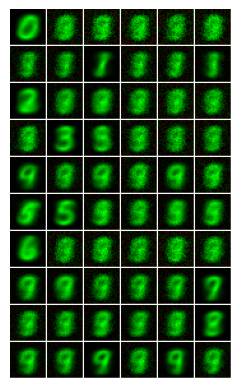

In [ ]:
import os

directory = '/content/png'

if not os.path.exists(directory):
    os.makedirs(directory)


width = 28
height = 28
img = GenerateImagesOfWeights(width, height, color='color', rows=C, cols=K, weight='diff')
plt.axis('off')
plt.imshow (img[0])
fn = f'/content/png/diff_MNIST_cce_pmEDWTA_epoch-{epoch}_acc-{outVal}.png'
plt.imsave(fn, img[0])

img = GenerateImagesOfWeights(width, height, color='color', rows=C, cols=K, weight='pos')
plt.axis('off')
plt.imshow (img[0])
fn = f'/content/png/pos_MNIST_cce_pmEDWTA_epoch-{epoch}_acc-{outVal}.png'
plt.imsave(fn, img[0])

img = GenerateImagesOfWeights(width, height, color='color', rows=C, cols=K, weight='neg')
plt.axis('off')
plt.imshow (img[0])
fn = f'/content/png/neg_MNIST_cce_pmEDWTA_epoch-{epoch}_acc-{outVal}.png'
plt.imsave(fn, img[0])
